<a href="https://colab.research.google.com/github/Pedro-Boechat/recommendation-system/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Systems

Recommendation systems are being more and more used by platforms in order to maximize sales and costumer satisfaction.

There are two main principles to recommendation systems:

- Collaborative filtering: In this case, recommendations are made based on the likes and dislikes of users who are similar to the target. This means that if both users liked X product, and one of them also likes Y product, the other one probably will like it too.

- Content-based filtering: On the other hand, content-based filtering works by recommending items that share features with an item the user has liked in the past.

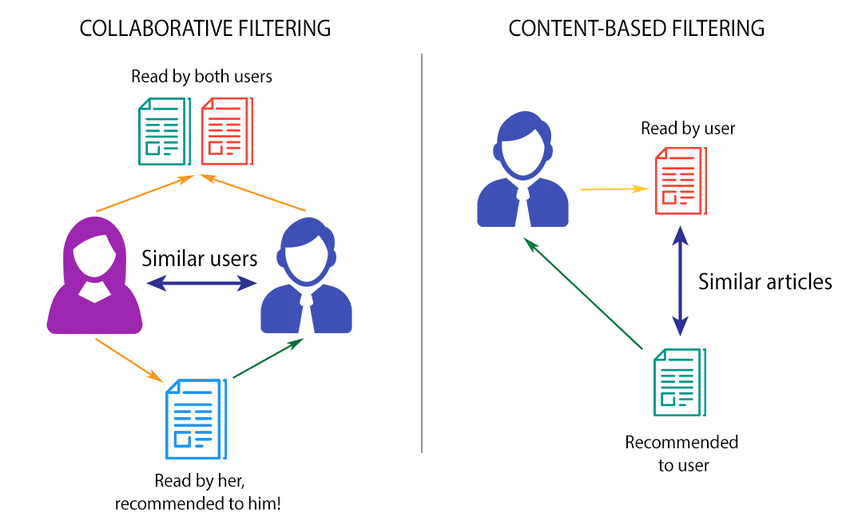

Today we will use collaborative filtering to build a movie recommendation system.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

In [ ]:
# Creating the dataloader (necessary for PyTorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader # package that helps transform your data to machine learning readiness

In [ ]:
df = pd.read_csv('Dataset.csv')
df_ids = pd.read_csv('Movie_Id_Titles.csv')

In [ ]:
df.shape

(100003, 4)

In [ ]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


<Axes: xlabel='count', ylabel='rating'>

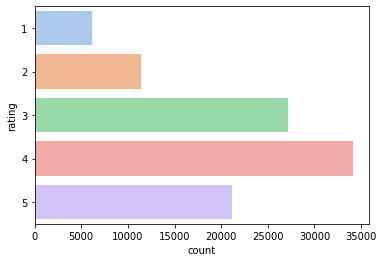

In [ ]:
sns.countplot(y='rating', data=df, palette='pastel')

Here we can see how distributed our ratings are. There is a concentration of ratings around 3 and 4 stars.

In [ ]:
n_items = len(df.item_id.unique())
n_users = len(df.user_id.unique())
print(f'We have {n_items} movies and {n_users} users')
print(f'This means the matrix of ratings should have {n_items * n_users} elements. It has {df.shape[0]} elements, which shows that our matrix is only {df.shape[0]/(n_items*n_users)*100}% filled. This is natural for this kind of problem.')

We have 1682 movies and 944 users
This means the matrix of ratings should have 1587808 elements. It has 100003 elements, which shows that our matrix is only 6.298179628771237% filled. This is natural for this kind of problem.


In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.4)
        self.item_factors.weight.data.uniform_(0, 0.4)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)
    
    def predict(self, user, item):
        return self.forward(user, item)
     

In [ ]:
# This class is responsible for loading and process the dataset, which is mandatory for pytorch

class Loader(Dataset):

    def __init__(self):
        self.ratings = df.copy()
        
        # Extract all user IDs and movie IDs
        users = df.user_id.unique()
        movies = df.item_id.unique()
        
        # Making so that the IDs are continuous for users and movies
        
        # Unique values : index
        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}
        
        # Obtained continuous ID for users and movies
        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}
        
        # Switch id from the indexed values as noted in the lambda function down below.
        self.ratings.item_id = df.item_id.apply(lambda x: self.movieid2idx[x])
        self.ratings.user_id = df.user_id.apply(lambda x: self.userid2idx[x])
        
        
        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models.)

    # Auxiliary functions

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

In [ ]:
n_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# GPU enable
model = model.cuda()

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,capturable=True)


# Train data
train_set = Loader()
train_loader = DataLoader(train_set, 128, shuffle=True)

Is running on GPU: True
MatrixFactorization(
  (user_factors): Embedding(944, 8)
  (item_factors): Embedding(1682, 8)
)
user_factors.weight tensor([[0.0415, 0.2441, 0.3804,  ..., 0.1369, 0.1130, 0.2708],
        [0.2175, 0.0745, 0.1280,  ..., 0.0803, 0.2708, 0.3681],
        [0.0512, 0.2153, 0.0887,  ..., 0.1803, 0.3889, 0.0261],
        ...,
        [0.1811, 0.0964, 0.2026,  ..., 0.3318, 0.2192, 0.3211],
        [0.0773, 0.3559, 0.3001,  ..., 0.3535, 0.0331, 0.1535],
        [0.0340, 0.2794, 0.2943,  ..., 0.2943, 0.2017, 0.0131]])
item_factors.weight tensor([[0.3097, 0.2013, 0.1906,  ..., 0.3266, 0.1882, 0.0224],
        [0.3050, 0.2703, 0.3499,  ..., 0.1137, 0.2079, 0.0875],
        [0.3130, 0.3931, 0.3481,  ..., 0.3651, 0.2249, 0.2237],
        ...,
        [0.2170, 0.2108, 0.3572,  ..., 0.3951, 0.0908, 0.1838],
        [0.0124, 0.1274, 0.1838,  ..., 0.3610, 0.1327, 0.3957],
        [0.2787, 0.0678, 0.3061,  ..., 0.1554, 0.3749, 0.2659]])


In [ ]:
class Model_Train():
  def __init__(self, n_epochs, data):
    for it in tqdm(range(n_epochs)):
      losses = []
      for x, y in data:
          if cuda:
              x, y = x.cuda(), y.cuda()
              optimizer.zero_grad()
              outputs = model(x)
              loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
              losses.append(loss.item())
              loss.backward()
              optimizer.step()
      print("iter #{}".format(it), "Loss:", sum(losses) / len(losses))

In [ ]:
Model_Train(n_epochs=128, data=train_loader)

<ipython-input-68-e6c722fc11db>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(n_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

iter #0 Loss: 7.866265371937276
iter #1 Loss: 2.22632809185311
iter #2 Loss: 1.1671337239882524
iter #3 Loss: 0.9787751151167828
iter #4 Loss: 0.9144384199396118
iter #5 Loss: 0.8881490015617722
iter #6 Loss: 0.8745047665008193
iter #7 Loss: 0.8666162068581642
iter #8 Loss: 0.8624904695374277
iter #9 Loss: 0.8584857878020352
iter #10 Loss: 0.8556322762575905
iter #11 Loss: 0.8528616489351862
iter #12 Loss: 0.8508556885335147
iter #13 Loss: 0.8478907184375216
iter #14 Loss: 0.8456167700650442
iter #15 Loss: 0.8429022576193066
iter #16 Loss: 0.8402806020453762
iter #17 Loss: 0.8373089935773473
iter #18 Loss: 0.8349455488307397
iter #19 Loss: 0.8307128749082765
iter #20 Loss: 0.8270241017155635
iter #21 Loss: 0.8234937414336387
iter #22 Loss: 0.818311056212696
iter #23 Loss: 0.8142424315747703
iter #24 Loss: 0.8089310444529404
iter #25 Loss: 0.8032261582134325
iter #26 Loss: 0.7971294891194004
iter #27 Loss: 0.790946948253895
iter #28 Loss: 0.7844575087127783
iter #29 Loss: 0.777223455174

In [ ]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data
        #print('param_data', param_data)

# We can see that the weights were, in fact, changed. This means our algorithm worked.

user_factors.weight tensor([[-0.6762,  0.5290,  0.5541,  ...,  2.9793,  1.2444, -0.4785],
        [ 0.8081,  0.8400,  0.9247,  ...,  0.0434,  0.2986,  0.3362],
        [ 0.2530, -0.5975,  1.0025,  ...,  0.8363,  1.3702,  0.2670],
        ...,
        [ 0.1341, -0.5820,  1.2090,  ...,  0.3953,  0.8921,  1.4233],
        [ 0.8885,  1.1606,  0.7398,  ..., -0.2172,  1.1214,  0.7420],
        [ 0.5066,  0.3998,  0.8044,  ...,  0.6930,  0.4540,  1.2228]],
       device='cuda:0')
item_factors.weight tensor([[ 0.7165,  1.2986,  1.1291,  ...,  0.9849,  0.6564,  0.2900],
        [ 0.7911,  1.2411,  1.0935,  ...,  0.8830,  0.7410,  0.1280],
        [ 1.3379,  0.8874,  1.4110,  ..., -0.0122,  0.3536,  0.2992],
        ...,
        [ 0.6590,  0.6537,  0.7766,  ...,  0.7504,  0.5265,  0.6143],
        [ 0.5099,  0.6268,  0.6552,  ...,  0.6656,  0.6243,  0.8795],
        [ 0.7411,  0.5315,  0.7448,  ...,  0.5384,  0.8289,  0.7168]],
       device='cuda:0')


In [ ]:
trained_movie_embeddings = model.item_factors.weight.data.cpu().numpy()

In [ ]:
len(trained_movie_embeddings) # unique movie factor weights

1682

In [ ]:
from sklearn.cluster import KMeans
# Fit the clusters based on the movie weights
kmeans = KMeans(n_clusters=12, random_state=0).fit(trained_movie_embeddings)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
movie_names = df_ids.set_index('item_id')['title'].to_dict()

In [ ]:
# Note from this result that similar movies are in the same clusters. It is worth mentioning that the algorithm doesn't know the movie titles
# This clustering is only provided by the numbers of the weights, and have no biases around the names of the items.

for cluster in range(12):
  print("Cluster #{}".format(cluster))
  movs = []
  for movidx in np.where(kmeans.labels_ == cluster)[0]:
    movid = train_set.idx2movieid[movidx]
    rat_count = df.loc[df['item_id']==movid].count()[0]
    movs.append((movie_names[movid], rat_count))
  for mov in sorted(movs, key=lambda tup: tup[1], reverse=True)[:20]:
    print("\t", mov[0])

Cluster #0
	 Truth About Cats & Dogs, The (1996)
	 Sleepless in Seattle (1993)
	 Ghost (1990)
	 Dragonheart (1996)
	 Last of the Mohicans, The (1992)
	 Michael (1996)
	 Star Trek: The Motion Picture (1979)
	 Dirty Dancing (1987)
	 Spitfire Grill, The (1996)
	 Three Musketeers, The (1993)
	 First Knight (1995)
	 Beautician and the Beast, The (1997)
	 Up Close and Personal (1996)
	 Somewhere in Time (1980)
	 Santa Clause, The (1994)
	 Legends of the Fall (1994)
	 Picture Perfect (1997)
	 Dolores Claiborne (1994)
	 Crucible, The (1996)
	 Circle of Friends (1995)
Cluster #1
	 Pulp Fiction (1994)
	 Twelve Monkeys (1995)
	 Monty Python and the Holy Grail (1974)
	 Terminator, The (1984)
	 Blade Runner (1982)
	 Clockwork Orange, A (1971)
	 Brazil (1985)
	 Fifth Element, The (1997)
	 This Is Spinal Tap (1984)
	 Cop Land (1997)
	 Monty Python's Life of Brian (1979)
	 Rumble in the Bronx (1995)
	 Full Metal Jacket (1987)
	 Mother (1996)
	 Everyone Says I Love You (1996)
	 Grosse Pointe Blank (199